# Modeling and Insights

This notebook contains data preprocessing and modeling for the prediction of water extraction potential in Germany.

Contents

[Load data](#load-data)

[Preprocessing and feature engineering](#preprocessing-and-feature-engineering)

[Modeling](#modeling)

[Interpretation](#interpretation)

In [1]:
# Import necessary packages
from dbfread import DBF
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyhere import here
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load data


In [2]:
# datasets not provided as csvs. 
# screen folder for .dbf, .shp, files, load as (geo)pandas dfs, save (g)dfs in dicts with filenames as keys
# for plotting, transform to geographical crs 
dfs = {}
gdfs = {}
folder_path = here("ERGW1000/ERGW1000_v1/shp")
for file in os.listdir(folder_path):
    if file.endswith(".dbf"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".dbf", "")
        path_to_file = os.path.join(folder_path, file)
        table = DBF(path_to_file, load=True,  encoding="utf-8")
        #convert to pandas df
        df = pd.DataFrame(iter(table))
        #save to dict
        dfs[filename] = df
    if file.endswith(".shp"):
        # create short filename
        filename = file.replace("ergw1000_", "").replace(".shp", "")
        path_to_shapefile = os.path.join(folder_path, file)
        gdf = gpd.read_file(path_to_shapefile)
        gdf = gdf.to_crs(epsg=4326)
        #save to dict
        gdfs[filename] = gdf

In [3]:
# load datasets for modeling

# mining data
mining_gdf = gdfs['bergbaugebiete__v1_poly']

# groundwater data 
water_gdf = gdfs['gwerg__v11_poly'] 


### Preprocessing and feature engineering

<Axes: >

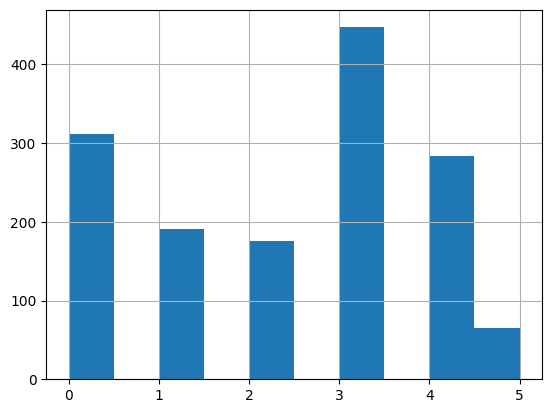

In [4]:
# Target variable: numerical oridinal encoding
water_gdf['entn_bru'] = water_gdf['entn_bru'].fillna('None') # none for no extraction at all
entn_dict = {'None': 0, 'meist < 2 (l/s)': 1, 'meist < 5 (l/s)': 2, 'meist 5 - 15 (l/s)': 3, 'meist 15 - 40 (l/s)': 4, 'meist > 40 (l/s)': 5}
y = water_gdf['entn_bru'].map(entn_dict)
y.hist()

In [5]:
# Feature 1: 'gestein' dummy encoded
# replace missing "gestein" with string
water_gdf['gestein'] = water_gdf['gestein'].astype('str')
# one hot encoding of gestein
gestein_encoded = pd.get_dummies(water_gdf["gestein"], prefix="gestein")
water_gdf = pd.concat([water_gdf, gestein_encoded], axis=1)

In [6]:
# Feature 2: 'Bedeutung' label encoded (ordinal)
# replace missing with string
water_gdf['bedeutung'] = water_gdf['bedeutung'].astype('str')
bedeut_dict = {'None': 0, 'Keine bedeutenden Grundwasservorkommen': 1, 'Weniger bedeutende Grundwasservorkommen': 2, 'Bedeutende Grundwasservorkommen': 3}
water_gdf['bedeutung_cat'] = water_gdf['bedeutung'].map(bedeut_dict)


<Axes: >

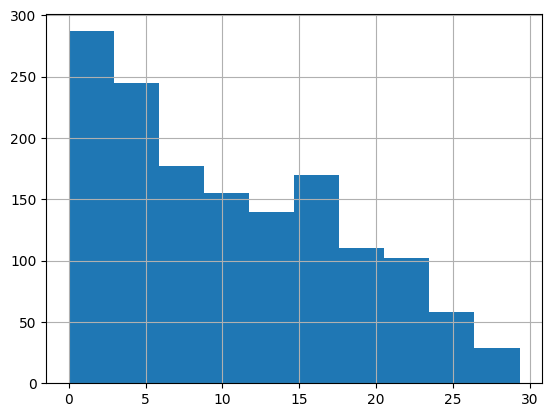

In [7]:
# Feature 3: Distance of each groundwater geometry centroid to nearest mining polyline

# Reproject both datasets
projected_crs = "EPSG:32632"
water_gdf = water_gdf.to_crs(projected_crs)
mining_gdf = mining_gdf.to_crs(projected_crs)

# Get centroids of water source areas
water_centroid = water_gdf.geometry.centroid

# Compute distance from each centroid to the nearest mining polyline
water_gdf["distance_to_mining"] = water_centroid.apply(
    lambda point: mining_gdf.geometry.distance(point).min() / 1_0000 # to km
)
water_gdf["distance_to_mining"].hist()

<Axes: >

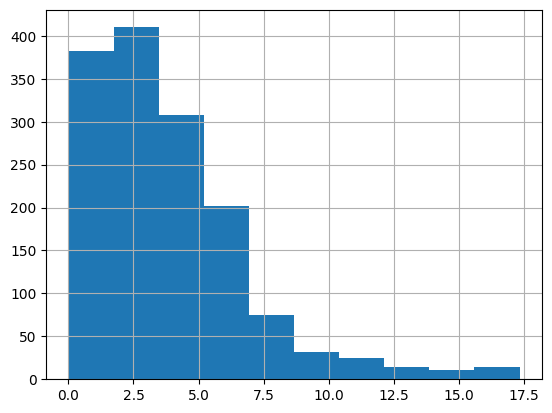

In [8]:
# Feature 4: Proximity to rivers or lakes

bank_gdf = gdfs['uferfiltrat__v1_line']
# tconvert o projected crs
bank_gdf = bank_gdf.to_crs(projected_crs)

# Compute distance from each water area centroid to the nearest waterbank
water_gdf["distance_to_waterbanks"] = water_centroid.apply(
    lambda point: bank_gdf.geometry.distance(point).min() / 1_0000) # to km

# check distribution of distance
water_gdf.distance_to_waterbanks.hist()

<Axes: >

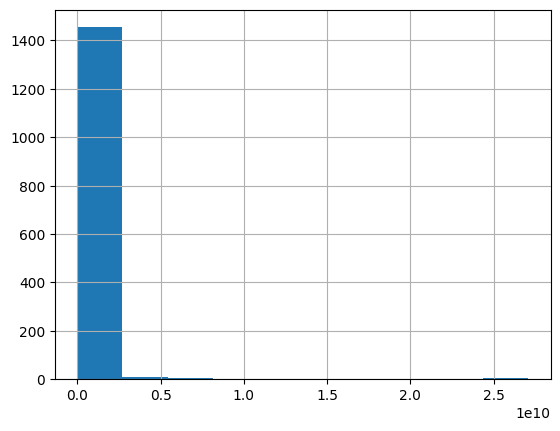

In [9]:
# Feature 5: area log transformed (because it is shighly skewed)
water_gdf['Shape_STAr'].hist()

<Axes: >

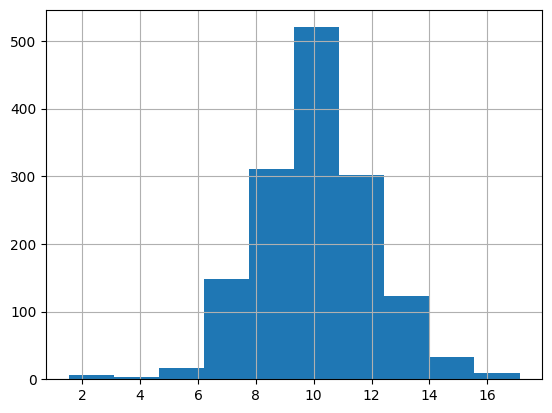

In [10]:
water_gdf['log_area'] = np.log(water_gdf['Shape_STAr'] / 1_000 )
water_gdf['log_area'].hist()


In [11]:
# feature 6: spatial features (lat and lon)
water_gdf["longitude"] = water_gdf.geometry.centroid.x
water_gdf["latitude"] = water_gdf.geometry.centroid.y

In [12]:
# Define feature array (X)
X = water_gdf.drop(columns = ['erg_id','entn_werk', 'gestein_id', 'ergiebigke', 'bedeutung', 'entn_bru', 'gestein', 'Shape_STAr', 'Shape_STLe', 'geometry', ])

In [13]:
X

,"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",gestein_None,"gestein_Sand, Kies, Tuff (Porenwasserleiter)","gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",bedeutung_cat,distance_to_mining,distance_to_waterbanks,log_area,longitude,latitude
0,False,False,True,False,3,27.599427,12.776758,14.309971,499587.197126,6.061468e+06
1,False,True,False,False,1,28.379206,16.350886,9.315953,455561.659604,6.080240e+06
2,False,False,True,False,3,27.430476,15.618993,9.202513,454138.422403,6.070860e+06
3,False,False,True,False,3,28.869077,12.454141,12.194188,527575.658100,6.064266e+06
4,False,False,True,False,3,28.714522,14.033133,9.734217,497277.217639,6.073935e+06
...,...,...,...,...,...,...,...,...,...,...
1468,True,False,False,False,3,2.843375,2.883728,10.331405,379992.471582,5.756160e+06
1469,False,False,True,False,3,0.046231,0.200276,14.896652,334969.628401,5.693215e+06
1470,False,False,True,False,3,2.314534,3.224579,9.603864,350858.157996,5.751519e+06
1471,False,False,True,False,3,0.675877,3.686623,13.100758,369398.640716,5.737250e+06


### Modeling

In [14]:
# check correlation matrix
corr_matrix = pd.concat([y, X], axis=1).corr()
corr_matrix 

,entn_bru,"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",gestein_None,"gestein_Sand, Kies, Tuff (Porenwasserleiter)","gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",bedeutung_cat,distance_to_mining,distance_to_waterbanks,log_area,longitude,latitude
entn_bru,1.000000,0.166800,-0.873283,0.616486,0.180619,0.948756,-0.034624,-0.129857,0.390414,-0.152889,-0.215779
"gestein_Kalkstein, Dolomit, Gips (Karstwasserleiter)",0.166800,1.000000,-0.230710,-0.278786,-0.123845,0.189961,-0.102631,-0.021229,0.148152,-0.154640,-0.170600
gestein_None,-0.873283,-0.230710,1.000000,-0.632309,-0.280890,-0.931659,0.087507,0.055715,-0.373279,0.096962,0.164188
"gestein_Sand, Kies, Tuff (Porenwasserleiter)",0.616486,-0.278786,-0.632309,1.000000,-0.339423,0.621144,0.100051,-0.068665,0.138401,0.110993,0.061198
"gestein_Sandstein, Quarzit, Basalt, Kalkmergelstein (Kluftwasserleiter)",0.180619,-0.123845,-0.280890,-0.339423,1.000000,0.236064,-0.182028,0.040636,0.194994,-0.166782,-0.174577
bedeutung_cat,0.948756,0.189961,-0.931659,0.621144,0.236064,1.000000,-0.080912,-0.094108,0.420825,-0.176928,-0.184853
distance_to_mining,-0.034624,-0.102631,0.087507,0.100051,-0.182028,-0.080912,1.000000,0.348098,-0.159142,0.027915,0.055845
distance_to_waterbanks,-0.129857,-0.021229,0.055715,-0.068665,0.040636,-0.094108,0.348098,1.000000,-0.176913,0.068589,0.360009
log_area,0.390414,0.148152,-0.373279,0.138401,0.194994,0.420825,-0.159142,-0.176913,1.000000,-0.232019,-0.272912
longitude,-0.152889,-0.154640,0.096962,0.110993,-0.166782,-0.176928,0.027915,0.068589,-0.232019,1.000000,0.132958


In [15]:
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [17]:
# Compute error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.26301694915254237
Mean Squared Error (MSE): 0.1842823728813559
R² Score: 0.9129389189277223


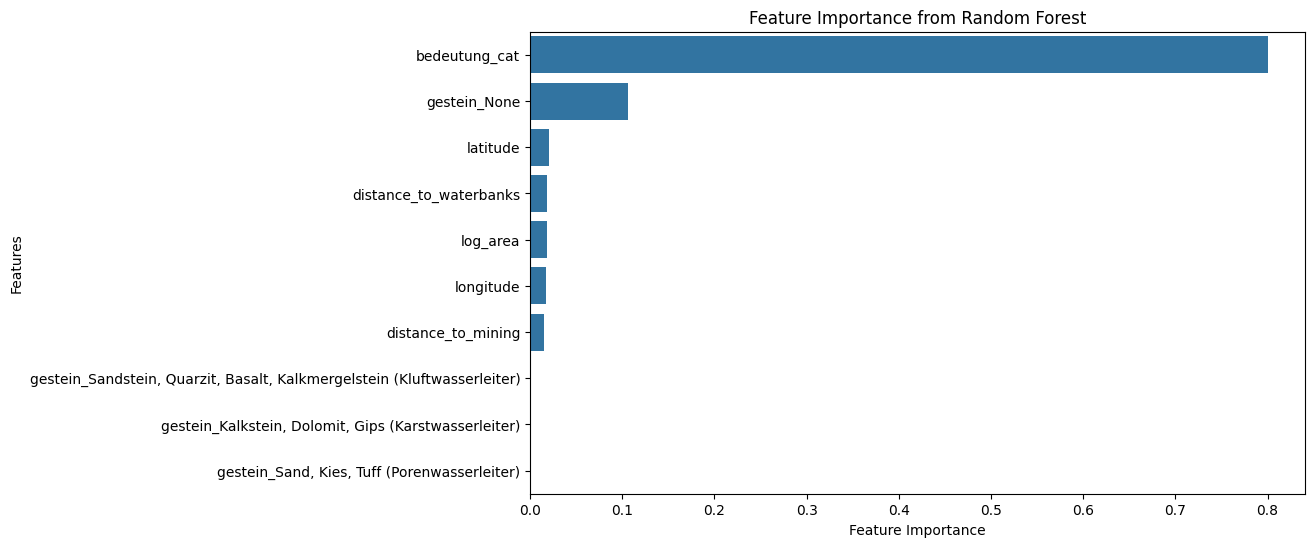

In [18]:
#Get feature importance
feature_importance = model.feature_importances_
features = X.columns


# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]  # Sort in descending order
sorted_features = np.array(features)[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest")
plt.show()

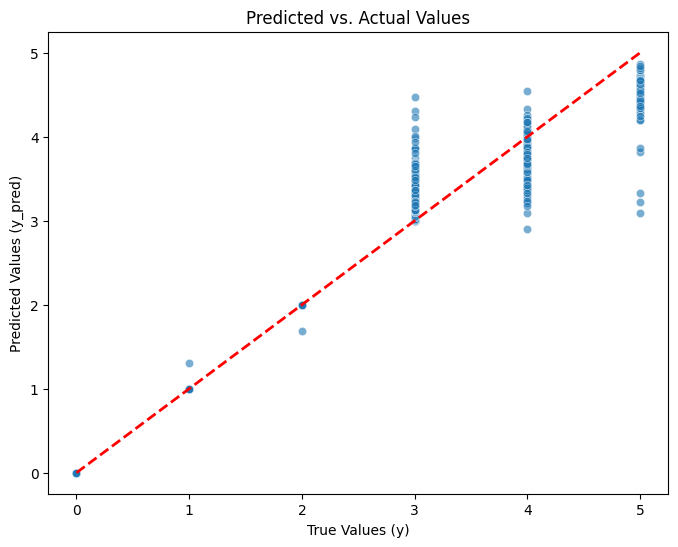

In [19]:
# make overfitting predictions for all data and plot y_true againd y_pred
y_pred_all = model.predict(X)

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred_all, alpha=0.6)

# Add a diagonal reference line (perfect predictions)
min_val = min(min(y), min(y_pred_all))
max_val = max(max(y), max(y_pred_all))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

# Labels and title
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Predicted vs. Actual Values")

plt.show()


### Interpretation

 
The goal was to fit a basic predictive model for estimating **potential water extraction yield** (`ent_bru`) at a well.  

- The **target variable** (`ent_bru`) is **ordinal**, ranging from **0** (no extraction potential) to **5** (highest extraction potential).  
- Ideally, an **ordinal regression model** (e.g., **ordinal ridge regression**) should be used, but for simplicity, it is treated as **continuous**.  
- A **random forest regression model** was fitted using an **80-20 train-test split**, with **no cross-validation** or **hyperparameter tuning**.  

---

## **Feature Engineering**  
The following features were included in the model:  

- **Geological formations** → One-hot encoded  
- **Log-transformed area** of water-bearing geographies → `log_area = log(Shape_STAr)`  
- **Distance to nearest waterbank** (in km) → `distance_to_waterbank`  
- **Distance to nearest mining area** (in km) → `distance_to_mining`  
- **Groundwater area importance** (`bedeutung_cat`) → Ordinal encoded (0-5)  
- **Latitude and Longitude of the centroids of the groundwater carrying areas** → more favorable geographies for water extraction (e.g. due to more precipitation)

---

## **Feature Importance Analysis**  

1. **`bedeutung_cat` (groundwater importance)** → Most predictive feature, but potentially biased due to being derived from a **secondary assessment** that correlates with `ent_bru`. This requires further investigation.  
2. **`gestein_None` (no significant geological formation in the area)** → Second most important feature for predicting `ent_bru`.  
3. **`distance_to_mining`, `distance_to_waterbank`, and `log_area`** → Also predictive, suggesting spatial and size-related dependencies. 
4. **`latitude`, `longitude`** → predictive, suggesting spatial location plays an important role independent of the factors already covered.  

> **⚠️ Potential Issue:**  
> - **Overfitting risk** due to potentially **non-independent** features (e.g., `bedeutung_cat`, `ergiebigke`, `entn_werk`).  
> - **Further refinement** could involve **removing dependent features** and **applying cross-validation**.  

---

## **Model Performance**  

| Metric  | Value | Interpretation |
|---------|------:|----------------|
| **MAE** | **~0.26** | On average, predictions deviate by **~0.26 units**. |
| **MSE** | **~0.18** | Larger errors are penalized more. Unusually, this is smaller than the MAE—requires further investigation. |
| **R² Score** | **~0.92** | The model explains **~92%** of variance, indicating a strong fit. |

---

## **Next Steps & Recommendations**  
- Investigate **feature dependencies** (`bedeutung_cat`, `ergiebigke`, `entn_werk`) to ensure true independence.  
- Apply **cross-validation** to assess generalization performance.  
- Consider **alternative models** (e.g., **ordinal regression**) since `ent_bru` is an **ordinal** target variable.  
- Evaluate the impact of further **spatial dependencies** on model performance.  


